1) Get Data

2) Preprocess Data

3) Transform Data / Preparing Data

4) Train Model

5) Test Model

6) Score, Iterate

1. How is your prediction task defined? And what is the meaning of the output variable?
    
    The prediction task is to predict whether a random machine fails or not. 
    The output variable, Machine Status, returns 1 if the machine failes and 0 if the machine is in normal condition.
    
    
2. How do you represent your data as features?
    

3. Did you process the features in any way?
       
       
4. How did you select which learning algorithms to use?


5. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?


6. How do you evaluate the quality of your system?


7. How well does your system compare to a stupid baseline?


8. Can you say anything about the errors that the system makes? For a classification task, you may consider a confusion matrix.


9. Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
# from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
# from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [13]:
!pip install imblearn  

In [3]:
data = pd.read_csv('Datasets/factory_data.csv')

data

,Unique ID,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
0,1,K12965,M,24.95,35.45,1551.0,42.8,0,0
1,2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
2,3,T20224,L,24.95,35.35,1498.0,49.4,5,0
3,4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
4,5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...,...
19995,19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19996,19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19997,19998,T83921,M,25.95,NaN,NaN,33.4,22,0
19998,19999,K42424,H,25.95,35.65,1408.0,48.5,25,0


## Convert dataset to X and y

In [4]:
X = data.drop('Machine Status', axis = 1)
y = data.iloc[:, -1]

In [5]:
print(X.isna().sum())

Unique ID                  0
Product ID                 0
Quality                  991
Ambient T (C)              0
Process T (C)            400
Rotation Speed (rpm)    1188
Torque (Nm)                0
Tool Wear (min)            0
dtype: int64


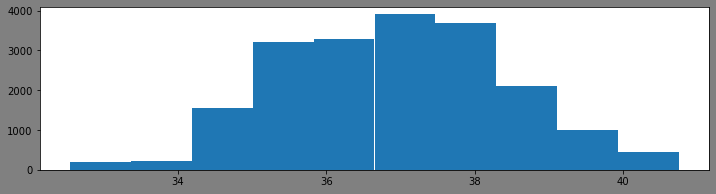

In [6]:
# From this histogram, 'Process T (C)' has a close to normal distribution
plt.figure(figsize = (12, 3), facecolor = 'gray')
plt.hist(X['Process T (C)'])
plt.show()

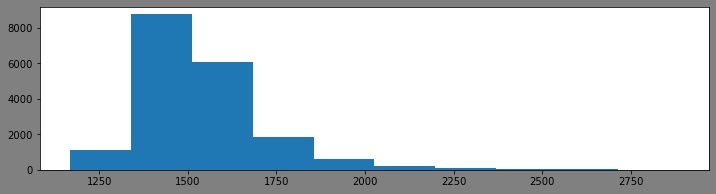

In [7]:
# From this histogram, 'Rotation Speed (rpm) has a positively skewed distribution'
plt.figure(figsize = (12, 3), facecolor = 'gray')
plt.hist(X['Rotation Speed (rpm)'])
plt.show()

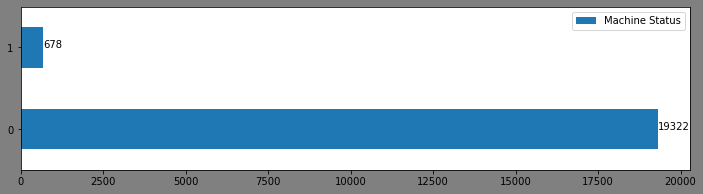

In [8]:
plt.figure(figsize = (12, 3), facecolor = 'gray')
ax = y.value_counts().plot(kind = 'barh', legend = True)
for p in range(len(ax.patches)):
    ax.annotate(ax.patches[p].get_width(), (ax.patches[p].get_width(), p))
plt.show()

In [9]:
# As 'Unique ID' and 'Product ID' are unique for all rows, they provide no meaning to the target variable. As such, the two features will be dropped
X_dropped = X.drop(['Unique ID', 'Product ID'], axis = 1)

In [10]:
X_dropped

,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
0,M,24.95,35.45,1551.0,42.8,0
1,L,25.05,35.55,1408.0,46.3,3
2,L,24.95,35.35,1498.0,49.4,5
3,L,25.05,35.45,1433.0,39.5,7
4,L,25.05,35.55,1408.0,40.0,9
...,...,...,...,...,...,...
19995,M,25.75,35.35,NaN,29.5,14
19996,H,25.85,35.35,1632.0,31.8,17
19997,M,25.95,NaN,NaN,33.4,22
19998,H,25.95,35.65,1408.0,48.5,25


In [11]:
transformer = ColumnTransformer([
    # Process T (C) column
    ('tnf1', SimpleImputer(missing_values=np.nan, strategy='mean'), [2]),
    # Rotation Speed (rpm) column
    ('tnf2', SimpleImputer(missing_values=np.nan, strategy='median'), [3]),
    # Quality column
    ('tnf3', SimpleImputer(missing_values=np.nan, strategy='most_frequent'), [0]),
], remainder = 'passthrough')

# Based on the ColumnTransformer above, column 'Process T (C)' is in index 0, column 'Rotation Speed (rpm) is in index 1, and column 'Quality' is in index 2
encoder = ColumnTransformer([
    ('enc', OrdinalEncoder(), [2])
], remainder = 'passthrough')

In [12]:
clf_name = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(random_state = 42), RandomForestClassifier(random_state = 42)]
score = {'Model': [], 'F1_Score': [], 'Precision': [], 'Recall': [], 'Accuracy': []}

for i in clf_name:
#     pipe = Pipeline([('impute', transformer), ('encoder', encoder), ('scaler', StandardScaler()), ('smote', SMOTE()), (f'{i}', i)])
    pipe = Pipeline([('impute', transformer), ('encoder', encoder), ('scaler', StandardScaler()), (f'{i}', i)])
    scores = cross_val_score(pipe, X_dropped, y, cv = 10, scoring = 'f1', n_jobs = -1)
    print(f'{i} has a F1 score of {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

LogisticRegression() has a F1 score of 0.26 with a standard deviation of 0.10
GaussianNB() has a F1 score of 0.24 with a standard deviation of 0.07
KNeighborsClassifier() has a F1 score of 0.58 with a standard deviation of 0.03
SVC() has a F1 score of 0.45 with a standard deviation of 0.08
DecisionTreeClassifier(random_state=42) has a F1 score of 0.88 with a standard deviation of 0.04
RandomForestClassifier(random_state=42) has a F1 score of 0.90 with a standard deviation of 0.03


In [12]:
for i in clf_name:
    pipe = Pipeline([('impute', transformer), ('encoder', encoder), ('scaler', StandardScaler()), ('smote', SMOTE()), (f'{i}', i)])
    scores = cross_val_score(pipe, X_dropped, y, cv = 10, scoring = 'f1', n_jobs = -1)
    print(f'{i} has a F1 score of {scores.mean():.2f} with a standard deviation of {scores.std():.2f}')

LogisticRegression() has a F1 score of 0.30 with a standard deviation of 0.15
GaussianNB() has a F1 score of 0.29 with a standard deviation of 0.12
KNeighborsClassifier() has a F1 score of 0.62 with a standard deviation of 0.09
SVC() has a F1 score of 0.46 with a standard deviation of 0.14
DecisionTreeClassifier(random_state=42) has a F1 score of 0.79 with a standard deviation of 0.08
RandomForestClassifier(random_state=42) has a F1 score of 0.91 with a standard deviation of 0.04


GridSearchCV on RandomForestClassifier

In [ ]:
pipe_randomforest = Pipeline([('impute', transformer), ('encoder', encoder), ('scaler', StandardScaler()), ('smote', SMOTE()), ('forest', RandomForestClassifier(random_state = 42))])

param_grid = { 
    'forest__n_estimators': [100, 200, 500],
    'forest__max_features': ['auto', 'sqrt', 'log2'],
    'forest__max_depth' : np.arange(10, 101, 20),
    'forest__criterion' :['gini', 'entropy']
}

grid = GridSearchCV(pipe_randomforest, param_grid, cv = 10, scoring = 'f1', n_jobs = -1)
grid.fit(X_dropped, y)

print(grid.best_score_)
print(grid.best_params_)

In [13]:
from sklearn.model_selection import RandomizedSearchCV

pipe_randomforest = Pipeline([('impute', transformer), ('encoder', encoder), ('scaler', StandardScaler()), ('smote', SMOTE()), ('forest', RandomForestClassifier(random_state = 42))])

param_grid = { 
    'forest__n_estimators': [200, 500],
    'forest__max_features': ['auto', 'sqrt', 'log2'],
    'forest__max_depth' : np.arange(10, 101, 20),
    'forest__criterion' :['gini', 'entropy']
}


grid2 = RandomizedSearchCV(pipe_randomforest, param_grid, n_iter = 20, cv = 10, scoring = 'f1', n_jobs = -1)
grid2.fit(X_dropped, y)

print(grid2.best_score_)
print(grid2.best_params_)

0.562694104695534
{'forest__n_estimators': 200, 'forest__max_features': 'log2', 'forest__max_depth': 8, 'forest__criterion': 'gini'}


In [38]:
print(grid.best_estimator_.named_steps['tree'].feature_importances_)

[0.06304999 0.11139929 0.20808001 0.07826658 0.3347431  0.20446104]


# IGNORE

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state = 25)

In [17]:
from sklearn.model_selection import GridSearchCV
pipe_final = Pipeline([('impute', transformer), ('encoder', encoder), ('scaler', StandardScaler()), ('logreg', LogisticRegression())])

params = {}
params['logreg__penalty'] = ['l1', 'l2', 'elasticnet']
params['logreg__C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
params['logreg__fit_intercept'] = [True, False]
params['logreg__solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

grid = GridSearchCV(pipe_final, params, cv = 10, scoring = 'f1')
grid.fit(X_test, y_test)

print(grid.best_score_)
print(grid.best_params_)

0.41230109587694724
{'logreg__C': 10, 'logreg__fit_intercept': True, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


C:\Users\chiaw\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1120 fits failed out of a total of 2100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chiaw\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chiaw\anaconda3\lib\site-packages\imblearn\pipeline.py", line 272, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\chiaw\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.pe

In [18]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp_mean.fit(X['Process T (C)'].values.reshape(-1, 1))
# X['Process T (C)'] = imp_mean.transform(X['Process T (C)'].values.reshape(-1, 1))

In [19]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
# imp_mean.fit(X['Rotation Speed (rpm)'].values.reshape(-1, 1))
# X['Rotation Speed (rpm)'] = imp_mean.transform(X['Rotation Speed (rpm)'].values.reshape(-1, 1))

In [20]:
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imp_mean.fit(X['Quality'].values.reshape(-1, 1))
# X['Quality'] = imp_mean.transform(X['Quality'].values.reshape(-1, 1))

In [21]:
# print(X.isna().sum())

In [22]:
enc = OrdinalEncoder()

X['Quality'] = enc.fit_transform(X['Quality'].values.reshape(-1, 1))

In [23]:
clf_name = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier()]
score = {'Model': [], 'F1_Score': [], 'Precision': [], 'Recall': [], 'Accuracy': []}

for i in clf_name:
    pipe = Pipeline([('Mean_Imputer', SimpleImputer(missing_values = np.nan, strategy = 'median')), (f'{i}', i)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    score['Model'].append(str(i).split('(')[0])
    score['F1_Score'].append(metrics.f1_score(y_test, y_pred, average = 'weighted'))
    score['Precision'].append(metrics.precision_score(y_test, y_pred, average = 'weighted'))
    score['Recall'].append(metrics.recall_score(y_test, y_pred, average = 'weighted'))
    score['Accuracy'].append(metrics.accuracy_score(y_test, y_pred))

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'M'

In [ ]:
pd.DataFrame(score, index = [0, 1, 2, 3, 4])